In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
from keras import applications
from keras import optimizers
from keras.models import Sequential, load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import *
from keras.layers import *
from keras.optimizers import Adagrad,Adam,RMSprop,SGD
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
from os import listdir
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from glob import glob
import re
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
total_images_train_normal = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/')
total_images_train_pneumonia = os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/')

In [3]:
total_images_train_normal

['NORMAL2-IM-1232-0001.jpeg',
 'NORMAL2-IM-0588-0001.jpeg',
 'NORMAL2-IM-0667-0001.jpeg',
 'NORMAL2-IM-0868-0001.jpeg',
 'IM-0413-0001.jpeg',
 'IM-0714-0001.jpeg',
 'IM-0297-0001.jpeg',
 'IM-0320-0001.jpeg',
 'NORMAL2-IM-1401-0001.jpeg',
 'NORMAL2-IM-0602-0001.jpeg',
 'NORMAL2-IM-1145-0001.jpeg',
 'IM-0446-0001.jpeg',
 'NORMAL2-IM-0952-0001.jpeg',
 'NORMAL2-IM-0863-0001.jpeg',
 'IM-0363-0001.jpeg',
 'IM-0656-0001-0002.jpeg',
 'NORMAL2-IM-0616-0001.jpeg',
 'IM-0439-0001-0001.jpeg',
 'NORMAL2-IM-1184-0001.jpeg',
 'IM-0282-0001.jpeg',
 'NORMAL2-IM-1190-0001.jpeg',
 'NORMAL2-IM-1209-0001.jpeg',
 'IM-0750-0001.jpeg',
 'IM-0623-0001.jpeg',
 'NORMAL2-IM-1044-0001.jpeg',
 'NORMAL2-IM-1242-0001.jpeg',
 'NORMAL2-IM-1203-0001.jpeg',
 'IM-0511-0001-0002.jpeg',
 'NORMAL2-IM-1280-0001.jpeg',
 'NORMAL2-IM-0845-0001.jpeg',
 'IM-0649-0001.jpeg',
 'NORMAL2-IM-0869-0001.jpeg',
 'NORMAL2-IM-0917-0001.jpeg',
 'IM-0289-0001.jpeg',
 'IM-0119-0001.jpeg',
 'NORMAL2-IM-0894-0001.jpeg',
 'NORMAL2-IM-0840-0001.jp

In [4]:
sample_normal = random.sample(total_images_train_normal,6)
sample_normal

['IM-0147-0001.jpeg',
 'NORMAL2-IM-0567-0001.jpeg',
 'IM-0503-0001.jpeg',
 'IM-0370-0001.jpeg',
 'NORMAL2-IM-0620-0001.jpeg',
 'NORMAL2-IM-0472-0001.jpeg']

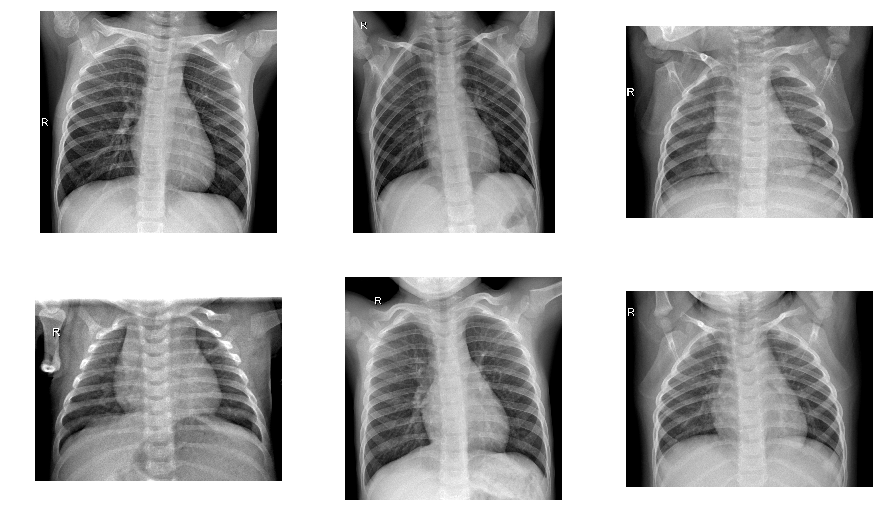

In [5]:
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
plt.show()

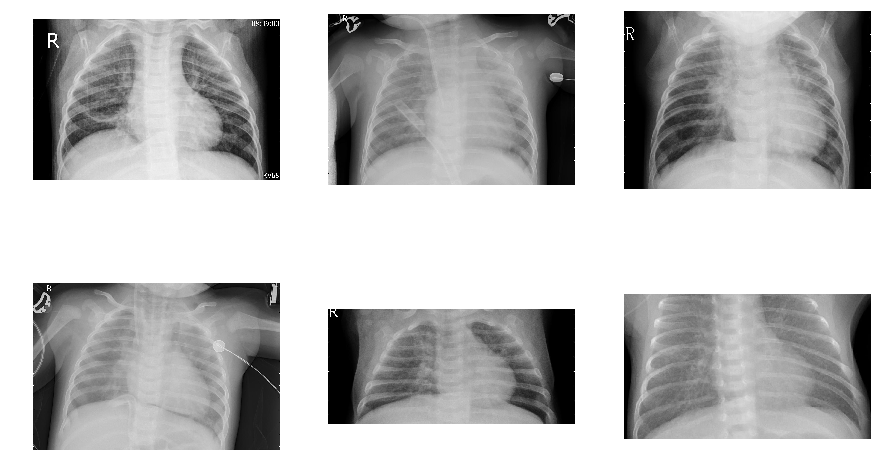

In [6]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
plt.show()

normal:  1342
pneumonia:  3876


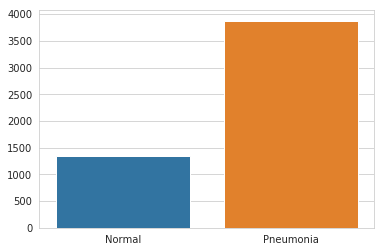

In [7]:
print('normal: ',len(total_images_train_normal))
print('pneumonia: ',len(total_images_train_pneumonia))
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

In [8]:
#defining some constant variables

height = 128
width = 128
batch_size = 32
no_of_epochs  = 10

In [9]:
# base_model & add_model
inceptionv3_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(width, height, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [10]:
add_model = Sequential()

add_model.add(Flatten(input_shape=inceptionv3_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model_v3 = Model(inputs=inceptionv3_model.input, outputs=add_model(inceptionv3_model.output))
model_v3.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

print('inceptionv3_model')

inceptionv3_model


In [11]:
print('model_v3','\n')
model_v3.summary()

model_v3 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/chest_xray/train',
                                                 target_size=(width, height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/chest_xray/test',
                                            target_size=(width, height),
                                            batch_size=batch_size,
                                            class_mode='categorical')
val_set= test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/chest_xray/val',
                                            target_size=(width, height),
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:


reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.001,
                                         verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks = [reduce_learning_rate,earlystop]

In [14]:
a_time=time.time()
a_time

1569048445.125672

In [15]:
str(round((time.time()-a_time)/60,2))

'0.0'

In [16]:
a_time=time.time()
history = model_v3.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=callbacks,verbose=1
                   )
print('inceptionv3_model', str(round((time.time()-a_time)/60,2)))

Epoch 1/10
163/163 [==============================] - 107s 657ms/step - loss: 0.4900 - acc: 0.7556 - val_loss: 0.6214 - val_acc: 0.6464
Epoch 2/10
163/163 [==============================] - 77s 473ms/step - loss: 0.3352 - acc: 0.8399 - val_loss: 0.5113 - val_acc: 0.7534
Epoch 3/10
163/163 [==============================] - 79s 485ms/step - loss: 0.2551 - acc: 0.9114 - val_loss: 0.3909 - val_acc: 0.8345
Epoch 4/10
163/163 [==============================] - 79s 482ms/step - loss: 0.2015 - acc: 0.9258 - val_loss: 0.3443 - val_acc: 0.8716
Epoch 5/10
163/163 [==============================] - 78s 480ms/step - loss: 0.1679 - acc: 0.9371 - val_loss: 0.4308 - val_acc: 0.8429
Epoch 6/10
163/163 [==============================] - 78s 477ms/step - loss: 0.1613 - acc: 0.9383 - val_loss: 0.3075 - val_acc: 0.8919
Epoch 7/10
163/163 [==============================] - 79s 485ms/step - loss: 0.1446 - acc: 0.9434 - val_loss: 0.3302 - val_acc: 0.8885
Epoch 8/10
163/163 [==============================] - 

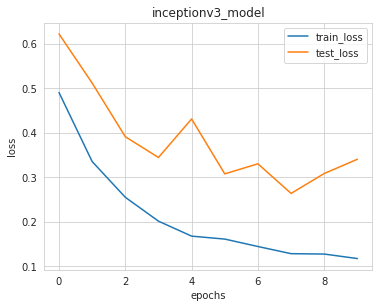

In [17]:
fg = plt.figure(figsize=(20,10))

ax2 = fg.add_subplot(232)
training_loss= history.history['loss']
testing_loss= history.history['val_loss']
plt.title('inceptionv3_model')
ax2.plot(training_loss, label='train_loss')
ax2.plot(testing_loss, label='test_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [18]:
model_v3.save('inceptionv3_model.h5')

In [19]:
model = load_model('inceptionv3_model.h5')

In [20]:
print("results")
result  = model.evaluate_generator(test_set, steps=len(test_set), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
20/20 [==============================] - 7s 354ms/step
Loss     : 0.25  
Accuracy : 91.67%


In [21]:
print("results")
y_pred = model.predict_generator(test_set, steps=len(test_set), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_set.classes

results
20/20 [==============================] - 7s 365ms/step


In [22]:
classes = ['Normal', 'Pneumonia']

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 61.57%
Recall        : 68.21%
F1-Score      : 64.72%
------------------------------------------------------------------------------------------





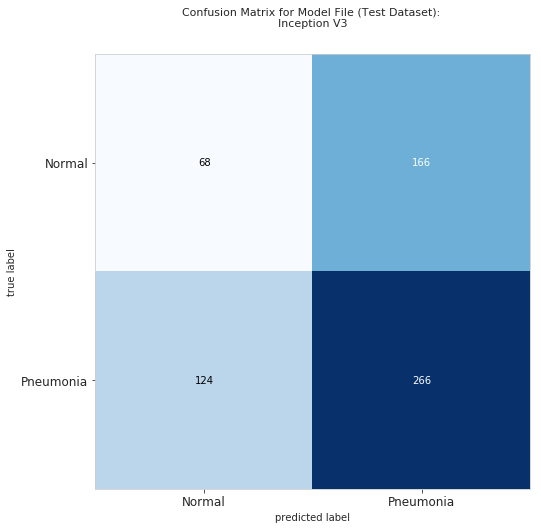




------------------------------------------------------------------------------------------
Report for Model File:  Inception V3
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.35      0.29      0.32       234
   Pneumonia       0.62      0.68      0.65       390

    accuracy                           0.54       624
   macro avg       0.48      0.49      0.48       624
weighted avg       0.52      0.54      0.52       624

------------------------------------------------------------------------------------------


In [23]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+'Inception V3', fontsize=11)
#fig.savefig(image_file_name_CM, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", 'Inception V3')
print("-"*90)
print(cls_report_print)
print("-"*90)

In [24]:
def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(128, 128))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    #pred_class = model.predict_classes(x)
    pred = model.predict(x)
    pred_class = pred.argmax(axis=-1)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    else:
        print("Predicted class: Pneumonia")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")        

Actual class: NORMAL
Predicted class: Pneumonia
Likelihood: 0.8081


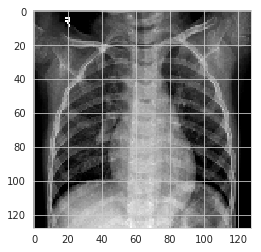

In [25]:
choose_image_and_predict()